In [18]:
from typing import Annotated
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage
from dotenv import load_dotenv
from IPython.display import Image, display
import gradio as gr
from langgraph.prebuilt import ToolNode, tools_condition
import requests
import os
from langchain_openai import ChatOpenAI
from typing import TypedDict
import json


In [20]:
load_dotenv()

True

## Tool :
Used to get the desired output in tool call , it is also like geeting a structured output using the tool , theen pass the information to other block

In [3]:
# Tool for my system
class city_info(TypedDict):
    """Search for the country information"""
    country_name: str
    country_capital: str
    currancy: str
    GDP: str

    

In [21]:
llm = ChatOpenAI(
    model = "gpt-4o-mini",
    temperature = 0.0,
)

In [5]:
llm_with_tools = llm.bind_tools(
    tools=[city_info]
)

In [6]:
response = llm_with_tools.invoke([HumanMessage(content="India")])

In [7]:
print(response)

content='' additional_kwargs={'tool_calls': [{'id': 'call_1dxnoVHjp4Gli9iDTfcxV51i', 'function': {'arguments': '{"country_name":"India","country_capital":"New Delhi","currancy":"Indian Rupee","GDP":"3.73 trillion USD"}', 'name': 'city_info'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 37, 'prompt_tokens': 60, 'total_tokens': 97, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-C1qZUUKZeP1yDkr6B9cC7Spvr9zvA', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None} id='run--019a4085-708f-4fd7-b2e7-41578ee93841-0' tool_calls=[{'name': 'city_info', 'args': {'country_name': 'India', 'country_capital': 'New Delhi', 'currancy': 'Indian Rupee', 'GDP': '3.73 trillion USD'}, 'i

In [8]:
print(response.additional_kwargs['tool_calls'][0]['function']['arguments'])

{"country_name":"India","country_capital":"New Delhi","currancy":"Indian Rupee","GDP":"3.73 trillion USD"}


In [9]:
info = response.additional_kwargs['tool_calls'][0]['function']['arguments']
final_info = json.loads(info)
print(final_info)

{'country_name': 'India', 'country_capital': 'New Delhi', 'currancy': 'Indian Rupee', 'GDP': '3.73 trillion USD'}


In [10]:
response =llm.invoke("what is the capital of India?")

In [11]:
print(response)

content='The capital of India is New Delhi.' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 8, 'prompt_tokens': 14, 'total_tokens': 22, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_62a23a81ef', 'id': 'chatcmpl-C1qZWAHDMTm2nDaD0SYAcoLzvH8Si', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None} id='run--74b5765c-cfe8-4a5a-8127-48bf06eda157-0' usage_metadata={'input_tokens': 14, 'output_tokens': 8, 'total_tokens': 22, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}


In [12]:
print(response.content)


The capital of India is New Delhi.


## Structured output:
We will use pydentic to get the structured output


In [13]:
from pydantic import BaseModel, Field

In [14]:
class student(BaseModel):
    name: str
    age: int
    city: str
    IIT_name: str

In [15]:
message = HumanMessage(
    content= "My name is alok and i am 27 years old, i done my Mtech from IIt Dharwad Karnataka. My birthplace is Chirawa."
)

In [16]:
llm_out = llm.with_structured_output(student).invoke([message])

In [17]:
print(llm_out)

name='Alok' age=27 city='Chirawa' IIT_name='IIT Dharwad'


## StateGraph
For building the stategraph, we need to define teh state first.
State is basically an immuateble time machine thing. It will passed to the each node and updated . The satte will contains all the pass updates . It means that it will not merge with the older messages

In [40]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [41]:

# Define the state

class State(TypedDict):
    messages: Annotated[list, add_messages]


In [42]:
graph_builder = StateGraph(State)

In [43]:
# Lets create a node
def ChatBot(Old_state:State):
    return {"messages": [llm.invoke(Old_state["messages"])]}



In [44]:
# Node Addition
graph_builder.add_node("ChatBot", ChatBot)
# Edge Addition
graph_builder.add_edge(START, "ChatBot")
graph_builder.add_edge("ChatBot", END)

# Compile the Graph
graph = graph_builder.compile(checkpointer=memory)

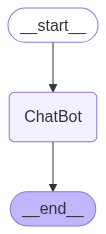

In [45]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [47]:
import gradio as gr
config = {"configurable": {"thread_id": "1"}}
def chat(user_input: str, history):
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]}, config= config)
    return result["messages"][-1].content


gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7864
* To create a public link, set `share=True` in `launch()`.


In [48]:
graph.get_state(config)

StateSnapshot(values={'messages': [HumanMessage(content='Hi my name is alok', additional_kwargs={}, response_metadata={}, id='2585b561-d565-46ca-9f14-8deb8e7cb6ad'), AIMessage(content='Hi Alok! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 13, 'total_tokens': 24, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-C1sJ69gCU31BXl3s9MZrMvHzuVi1B', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--898a6105-3a1a-42e5-9023-2f0e6f5b2c4d-0', usage_metadata={'input_tokens': 13, 'output_tokens': 11, 'total_tokens': 24, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}

In [49]:
list(graph.get_state_history(config))

[StateSnapshot(values={'messages': [HumanMessage(content='Hi my name is alok', additional_kwargs={}, response_metadata={}, id='2585b561-d565-46ca-9f14-8deb8e7cb6ad'), AIMessage(content='Hi Alok! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 13, 'total_tokens': 24, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-C1sJ69gCU31BXl3s9MZrMvHzuVi1B', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--898a6105-3a1a-42e5-9023-2f0e6f5b2c4d-0', usage_metadata={'input_tokens': 13, 'output_tokens': 11, 'total_tokens': 24, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}